# 8. `xarray` Plotting (I): Plotting 1-Dimensional Data

Visualizing data with clear and aesthetic figures is crucial for demonstrating results. xarray provides convenient methods to plot DataArray and Dataset objects directly. Below are various plotting options for different types of data:

**Single Variable Data (`xarray.DataArray.plot`):**

- **1D - Line Plot / Time Series Plot:** [`xarray.DataArray.plot.line`](http://xarray.pydata.org/en/stable/generated/xarray.plot.line.html#xarray.plot.line)
- **1D - Histogram:** [`xarray.DataArray.plot.hist`](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.plot.hist.html?highlight=hist)
- **1D - Step Plot:** [`xarray.DataArray.plot.step`](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.plot.step.html)

- **2D - Pseudocolor Plot:** [`xarray.DataArray.plot.pcolormesh`](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.plot.pcolormesh.html?highlight=pcolormesh)
- **2D - Filled Contour Map:** [`xarray.DataArray.plot.contourf`](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.plot.contourf.html)
- **2D - Contour Line Plot:** [`xarray.DataArray.plot.contour`](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.plot.contour.html)
- **2D - Contour Surface Plot (3D space):** [`xarray.DataArray.plot.surface`](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.plot.surface.html)

- **3D, 4D - Facet Grid Object:** Combine several plots using `row` and `col` options in plot methods.

**Multi-Variable Data (`xarray.Dataset.plot`):**

- **Scatter Plot:** [`xarray.Dataset.plot.scatter`](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.plot.scatter.html?highlight=dataset%20scatter)
- **Quiver Plot:** [`xarray.Dataset.plot.quiver`](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.plot.scatter.html?highlight=dataset%20scatter)
- **Streamplot:** [`xarray.Dataset.plot.streamplot`](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.plot.streamplot.html)

All xarray plotting methods support additional Matplotlib keyword arguments (`**kwargs`) for further customization.


## Time Series Plot

Plot using [`xarray.DataArray.plot.line`](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.plot.line.html). The xarray website provides clear instructions, but we will cover some advanced usage here.

### Fill-Between

**Example 1:** Calculate the pentad rainfall time series over the box area of Taiwan-North South China Sea (18˚-24˚N, 116˚-126˚E). Use a gray shaded area to represent the climatological maxima and minima, and use a thick black line to represent the climatological median.

We first read data, convert daily data to pentad, and calculate the maxima, minima, and median over 1998-2020. 

In [1]:
import xarray as xr 
from matplotlib import pyplot as plt
import pandas as pd 
import matplotlib as mpl
from matplotlib import ticker

mpl.rcParams['figure.dpi'] = 100

lats, latn = 18, 24                   
lon1, lon2 = 116,126         
ys = 1998    # Start year
ye = 2020    # End year

plt.rcParams.update({'font.size': 14})

def daily_to_pentad(data): 
    # To convert daily data to pentad. See Unit 5 for detail. 
    ptd = xr.DataArray(dims=['year','pentad'], 
                       coords=dict(year=range(ys,ye+1,1), 
                                   pentad=range(1,74,1),
                       name='precip')
    )
    for yy in ptd.year: 
        for p in ptd.pentad: 
            ptd.loc[yy,p] = data[ int((yy-1998)*365+ (p-1)*5) : int((yy-1998)*365+ (p-1)*5 + 4)  ].sum()
    return(ptd)
    
pcp_ds = xr.open_dataset('data/cmorph_sample.nc')
pcp = pcp_ds.sel(time=slice('1998-01-01','2020-12-31'),lat=slice(lats,latn),lon=slice(lon1,lon2)).cmorph 
    
pcp_ptd = daily_to_pentad(pcp.mean(axis=(1,2))) 

pcp_max = pcp_ptd.max(axis=0)
pcp_min = pcp_ptd.min(axis=0)
pcp_med = pcp_ptd.median(axis=0)

Using `plot.line()`, we can plot three lines: `pcp_max`, `pcp_med`, and `pcp_min`. To add a shaded area between the maxima and minima, we use `matplotlib.axes.Axes.fill_between`:

> `Axes.fill_between(x, y1, y2, **kwargs)`

Here, we specify the values of `x`, and the shaded area between `y1` and `y2` (or `pcp_max` and `pcp_min`).


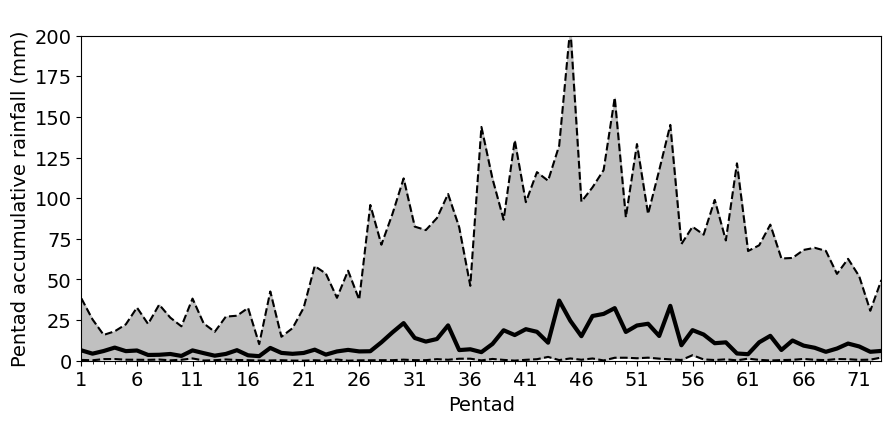

In [2]:
fig, ax = plt.subplots(1,1,figsize=(10,5))

maxl = pcp_max.plot.line(color='black',linestyle='--',
                         x='pentad', xlim=(1,73), ylim=(0,200),
                         ax=ax)
minl = pcp_min.plot.line(color='black',linestyle='--',
                         x='pentad', xlim=(1,73), ylim=(0,200),
                         ax=ax)
medl = pcp_med.plot.line(color='black',linestyle='-', linewidth=3,
                         x='pentad', xlim=(1,73), ylim=(0,200),
                         ax=ax)

ax.fill_between(pcp_ptd.pentad, pcp_max, pcp_min, color='silver')

ax.set_xticks(range(1,75,5))
ax.set_xticks(range(1,73),minor=True)
ax.set_xlabel('Pentad') 
ax.set_ylabel('Pentad accumulative rainfall (mm)')
ax.set_title(" ")

plt.subplots_adjust(left=0.1,bottom=0.15,top=0.8,right=0.9)

plt.show()

```{admonition} Exercise
:class: tip
Add a blue thick curve to represent the data in any year of your interest. 
```

### Twin Axes

Sometimes we need to plot two variables on a single plot. However, if the magnitudes of these two variables are very different, we use twin axes to set two different y (or x) axes. Below is an example from Hung and Yanai (2004) on the Australian summer monsoon.

**Example 2: Plot the Time Series of Australian Summer Monsoon Indices.**
The indices from [Hung and Yanai (2004, QJRMS)](https://rmets.onlinelibrary.wiley.com/doi/10.1256/qj.02.191) use 850-hPa zonal wind and OLR to estimate the monsoon onset. Since the magnitudes of wind and OLR are very different, we can plot them on the same figure using twin axes.

**Step 1:** Read the 850-hPa zonal wind and OLR data and select the spatial and temporal ranges.


In [3]:
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt

plt.rcParams.update({'font.size': 16})

# Set latitude, longitude parameters. 
lats, latn = -15, -2
lon1, lon2 = 110, 150
plev = 850

# Read data
uds = xr.open_mfdataset( ['data/ncep_r2_uv850/u850.2019.nc', 'data/ncep_r2_uv850/u850.2020.nc'], 
                           combine = "nested",               
                           concat_dim='time',          
                           parallel=True              
                         )
u = uds.sel(time=slice('2019-11-01','2020-03-31'), 
            level=850,
            lat=slice(latn,lats),
            lon=slice(lon1,lon2)).uwnd

olr = (xr.open_dataset("data/olr.nc")
         .sel(time=slice('2019-11-01','2020-03-31'),
                    lat=slice(lats,latn),
                    lon=slice(lon1,lon2)).olr)

Step 2: Analysis and computation: average wind and OLR indices over 2˚-15˚S, 110˚-130˚E according to Hung and Yanai (2004) paper.

In [4]:
# Spatial averages.
u_yh04   =   u.sel(lat=slice(-2,-15), lon=slice(115,150)).mean(axis=(1,2))
olr_yh04 = olr.sel(lat=slice(-15,-2), lon=slice(115,150)).mean(axis=(1,2))

**Step 3:** Plot the two indices. Because the magnitudes of OLR and wind are different, we need to create two plot axes, where `ax1` is used to plot 850-hPa zonal wind and `ax2` is used for OLR. Both `ax1` and `ax2` will share a common x-axis. We will display the wind field based on the left y-axis and OLR on the right y-axis. The common x-axis can be set using the `matplotlib.axes.Axes.twinx()` method.

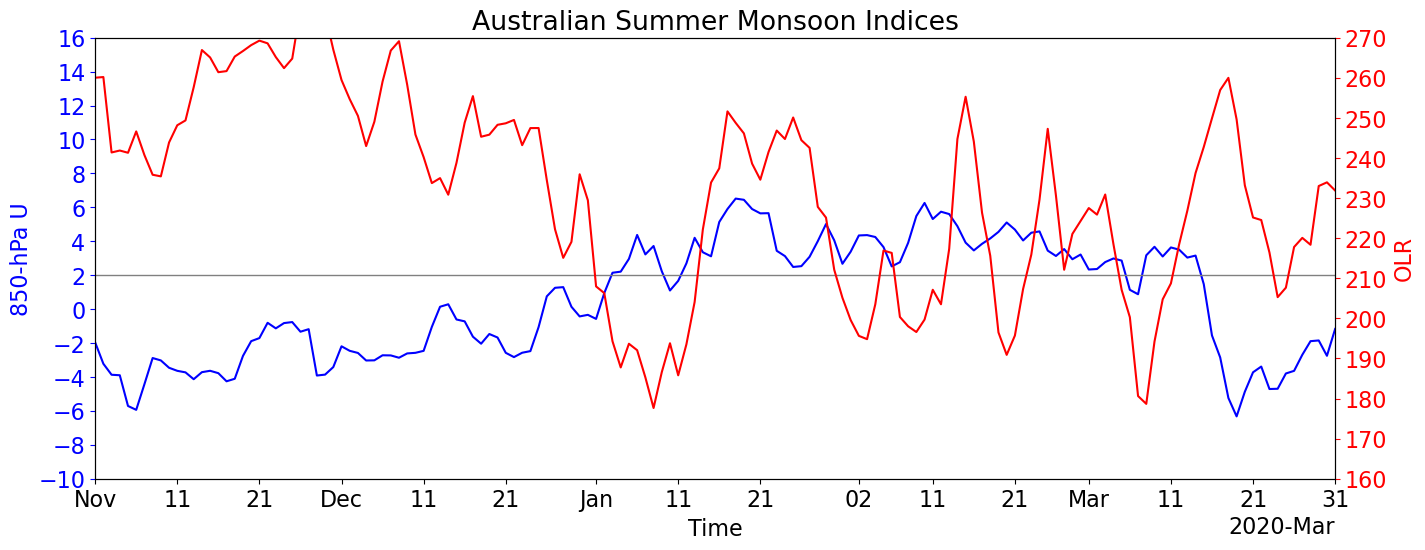

In [5]:
fig, ax1 = plt.subplots(figsize=(16,7))    
# Duplicate the axes with a different y axis and the same x axis
ax2 = ax1.twinx()  

# Plot u850 on ax1
u_yh04_plot = u_yh04.plot.line(u_yh04, color='blue',x='time', ylim=(-10,16) ,ax=ax1)
# Plot OLR on ax2
olr_plot = olr_yh04.plot.line(olr_yh04,color='red',x='time', ylim=(160,270),ax=ax2)

# Set the axis name and color. 
ax1.set_ylabel("850-hPa U", color='blue')
ax2.set_ylabel("OLR"      , color='red'  )
ax1.set_xlabel("Time") # ax2 has no property control over x axis

# Set y ticks
ax1.set_yticks(range(-10,18,2))
ax2.set_yticks(range(160,280,10))
ax1.tick_params(axis='y', colors='blue')
ax2.tick_params(axis='y', colors='red'  )
ax2.yaxis.label.set_color('red')

# set x ticks
xticks = pd.to_datetime(['2019-11-01','2019-11-11','2019-11-21','2019-12-01','2019-12-11','2019-12-21',
                         '2020-01-01','2020-01-11','2020-01-21','2020-02-02','2020-02-11','2020-02-21',
                         '2020-03-01','2020-03-11','2020-03-21','2020-03-31'])
ax1.set_xticks(xticks)
ax1.set_xlim(xticks[0],xticks[-1])
ax1.set_title('Australian Summer Monsoon Indices')

# u_yh04 = 2 m/s is the threshold of monsoon onset. 
ax1.axhline(y=2,linewidth=1,color='gray')

plt.subplots_adjust(bottom=0.25)

plt.show()
